<a href="https://colab.research.google.com/github/Pehlevan-Group/dmft_wide_networks/blob/main/deep_nonlinear_DMFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import random
import seaborn as sns
from jax.example_libraries import optimizers
from jax import grad, jit
import sys

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import jax
jax.devices()

gpu


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [ ]:

def get_phi_kernel(H):
    sqrt_diag = jnp.sqrt(jnp.diag(H)+5e-7)
    cosTheta = H / jnp.outer(sqrt_diag, sqrt_diag) 
    Phi = 1/(2*jnp.pi) * jnp.outer(sqrt_diag, sqrt_diag)*( jnp.sqrt(1-cosTheta**2) + (jnp.pi - jnp.arccos(cosTheta))*cosTheta ) 
    return Phi

# < phi'(x) phi'(z) > 
def get_dot_phi(H):
    sqrt_diag = jnp.sqrt(jnp.diag(H)+5e-7)
    cosTheta = H / jnp.outer(sqrt_diag, sqrt_diag) 
    Phi = 1/(2*jnp.pi) * ( jnp.pi - jnp.arccos(cosTheta) )
    return Phi

def initialize_kernels(Kx, depth, T):
    H = Kx * 1.0
    all_Phi = []
    for l in range(depth):
        Phi = get_phi_kernel(H)
        all_Phi += [Phi]
        H = Phi * 1.0
    
    all_G = [get_dot_phi(all_Phi[-1])]
    for l in range(depth-1):
        all_G.insert(0,  all_G[0] * get_dot_phi(all_Phi[-2-l]) )
    
    all_Phi_tp = []
    all_G_tp = []
    
    for l, Phil in enumerate(all_Phi):
        Gl = all_G[l]
        Phitp = np.zeros((T,P,T,P))
        Gtp = np.zeros((T,P,T,P))
        for t in range(T):
            for s in range(T):
                Phitp[t,:,s,:] = Phil
                Gtp[t,:,s,:] = Gl
        all_Phi_tp += [Phitp]
        all_G_tp += [Gtp]
    
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    return all_Phi_tp, all_G_tp, H0

def initialize_kernels_double(Kx, depth, T):
    H = Kx * 1.0
    all_Phi = []
    for l in range(depth):
        Phi = 2.0*get_phi_kernel(H)
        all_Phi += [Phi]
        H = Phi * 1.0
    
    all_G = [2.0*get_dot_phi(all_Phi[-1])]
    for l in range(depth-1):
        all_G.insert(0,  2.0*all_G[0] * get_dot_phi(all_Phi[-2-l]) )
    
    all_Phi_tp = []
    all_G_tp = []
    
    for l, Phil in enumerate(all_Phi):
        Gl = all_G[l]
        Phitp = np.zeros((T,P,T,P))
        Gtp = np.zeros((T,P,T,P))
        for t in range(T):
            for s in range(T):
                Phitp[t,:,s,:] = Phil
                Gtp[t,:,s,:] = Gl
        all_Phi_tp += [Phitp]
        all_G_tp += [Gtp]
    
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    return all_Phi_tp, all_G_tp, H0

# computes  < phi(h) phi(h) > for h Gaussian w covariance H
def draw_nonlin_samples_init(H, func, key, samples):
    S, V = jnp.linalg.eigh(H)
    S = S*(S>0.0)
    Z = random.normal(key, (H.shape[0], samples))
    SZ = jnp.einsum('i,ij->ij', S**(0.5), Z)
    h = V @ SZ
    phi = func(h)
    return phi @ phi.T / samples

# computes kernels at init
def initialize_kernels_sampling(Kx, depth, T, nonlin_fn, dnonlin_fn, samples = 1000):
    H = Kx * 1.0
    all_Phi = []
    key = random.PRNGKey(0)
    for l in range(depth):
        Phi = draw_nonlin_samples_init(H, nonlin_fn, key, samples)
        all_Phi += [Phi]
        H = Phi * 1.0
        key,_ = random.split(key)

      
    all_G = [draw_nonlin_samples_init(all_Phi[-2], dnonlin_fn, key, samples)  ]
    for l in range(depth-2):
        key,_ = random.split(key)
        all_G.insert(0,  all_G[0] * draw_nonlin_samples_init(all_Phi[-3-l], dnonlin_fn, key, samples) )
    all_G.insert(0, all_G[0] * draw_nonlin_samples_init(H, dnonlin_fn, key, samples))
    
    all_Phi_tp = []
    all_G_tp = []
    
    for l, Phil in enumerate(all_Phi):
        Gl = all_G[l]
        Phitp = np.zeros((T,P,T,P))
        Gtp = np.zeros((T,P,T,P))
        for t in range(T):
            for s in range(T):
                Phitp[t,:,s,:] = Phil
                Gtp[t,:,s,:] = Gl
        all_Phi_tp += [Phitp]
        all_G_tp += [Gtp]
    
    H0 = np.zeros((T,P,T,P))
    for t in range(T):
        for s in range(T):
            H0[t,:,s,:] = Kx
    
    return all_Phi_tp, all_G_tp, H0

def solve_Delta(Kx, y, all_Phi, all_G, eta):
    T = all_Phi[0].shape[0]
    P = all_Phi[0].shape[1]
    Delta = np.zeros((T,P))
    Delta[0,:] = y*1.0
    NTK = jnp.einsum('ijil,jl->ijl', all_G[0], Kx)
    depth = len(all_Phi)
    for l in range(depth-1):
        NTK += jnp.einsum('ijil,ijil->ijl', all_G[l+1], all_Phi[l])
    NTK += jnp.einsum('ijil->ijl', all_Phi[depth-1])
    
    for t in range(T-1):
        Delta[t+1,:] = Delta[t,:] - eta / P * NTK[t,:,:] @ Delta[t,:]    
    return Delta

def solve_self_consistent(Phi_minus, G_plus, Delta, chi, xi, eta_gam, num_step = 2500):
    
    h = chi * 1.0
    z = xi * 1.0
    P = Phi_minus.shape[1]
    
    Phi_tril = jnp.tril( Phi_minus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    G_tril = jnp.tril( G_plus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    for n in range(num_step):
        
        #phi = nonlin_fn(h)
        #g = z * dnonlin_fn(h)
        phi = h * (h > 0.0)
        g = z * (h>0.0)
        
        # g is samples x T x P Delta is T x P
        g_Delta = jnp.einsum('ijk,jk->ijk', g, Delta)
        phi_Delta = jnp.einsum('ijk,jk-> ijk', phi, Delta)
        
        dh = eta_gam / P * jnp.einsum('ijk,nmjk->inm', g_Delta,  Phi_tril)
        dz = eta_gam / P * jnp.einsum('ijk,nmjk->inm', phi_Delta, G_tril)
        
        #if n == 0:
        #    dh_check = np.zeros(g.shape)
        #    print(dh_check.shape)
        #    for t in range(1,T):
        #        for mu in range(P):
        #            C = Phi_minus[t,mu,:t,:] * Delta[:t,:]
        #            dh_check[:,t,mu] = eta_gam / P * jnp.einsum('ijk,jk->i', g[:,:t,:], C)
            
        #print("dh check")
        #print(jnp.mean((dh-dh_check)**2) / jnp.mean(dh**2) )
        
        h_new = 1.0*chi + dh
        z_new = 1.0*xi  + dz
        
        loss = ( jnp.sum((h_new-h)**2) + jnp.sum((z_new-z)**2) ) / (jnp.sum(h**2) + jnp.sum(z**2) )
        h = h_new 
        z = z_new
        if loss < 1e-10:
            break        
    return h, z



def solve_self_consistent_four_vars(Phi_minus, G_plus, A, B, Delta, t, r, nonlin_fn, dnonlin_fn, eta_gam, num_step = 500):
    h = t * 1.0
    z = r * 1.0
    P = Phi_minus.shape[1]
    
    causal_tt = jnp.tril( jnp.ones((T,T)), k=-1 )
    Phi_tril = jnp.einsum('ijkl,ik->ijkl', Phi_minus, causal_tt)
    C = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', Phi_tril, Delta) 
    
    G_tril = jnp.einsum('ijkl,ik->ijkl', G_plus, causal_tt)
    D = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', G_tril, Delta) 
    #update_h = jit( lambda h,z: t + jnp.einsum('ijk,mnjk->imn', z*dnonlin_fn(h), A+C) )
    #update_z = jit( lambda h: r + jnp.einsum('ijk,mnjk->imn', nonlin_fn(h), B + D) )
    for n in range(num_step):
        
        phi = nonlin_fn(h)
        g = z * dnonlin_fn(h)
        
        chi = t + jnp.einsum('ijk,mnjk->imn', g, A) # chi = t + A g
        xi = r + jnp.einsum('ijk,mnjk->imn', phi, B) # xi = r + B^T phi
        #chi = t 
        #xi = r 
        
        
        h_new = chi + jnp.einsum('ijk,mnjk->imn', g, C)
        z_new = xi + jnp.einsum('ijk,mnjk->imn', phi, D)
        #h_new = update_h(h,z)
        #z_new = update_z(h)
        
        loss = ( jnp.sum((h_new-h)**2) + jnp.sum((z_new-z)**2) ) / (jnp.sum(h**2) + jnp.sum(z**2) )
        h = h_new 
        z = z_new
        if loss < 1e-6:
            break        
    return h, z, chi,xi

# computes Jacobians  dh/du, dh/dr, dz/du, dz/dr
# takes in h, z which solve fixed point equations above 
# and calculates < dphi / dr > and < dg / du > for A, B 
def solve_jacobians_batched(Phi_minus, G_plus, A, B, Delta, h, z, nonlin_fn, dnonlin_fn, ddnonlin_fn, eta_gam, num_step = 30):
    P = Phi_minus.shape[1]
    causal_tt = jnp.tril( jnp.ones((T,T)), k=-1 )
    Phi_tril = jnp.einsum('ijkl,ik->ijkl', Phi_minus, causal_tt)
    C = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', Phi_tril, Delta) + A 
    
    G_tril = jnp.einsum('ijkl,ik->ijkl', G_plus, causal_tt)
    D = eta_gam / P * jnp.einsum('ijkl,kl->ijkl', G_tril, Delta) + B
    
    batch_size = 50
    num_batches = int(h.shape[0] / batch_size)
    dphi_dr_avg = jnp.zeros((T,P,T,P))
    dg_du_avg = jnp.zeros((T,P,T,P))
    
    for batch_n in range(num_batches):
        #sys.stdout.write('\r batch = %d' % batch_n)
        hb = h[batch_n*batch_size:(batch_n+1)*batch_size]
        zb = z[batch_n*batch_size:(batch_n+1)*batch_size]
        id_batch = jnp.einsum('i,jklm->ijklm', jnp.ones(batch_size), jnp.einsum('ik,jl->ijkl', jnp.eye(T), jnp.eye(P)))
        dh_du = id_batch # initial guess h ~ u + O(gamma)
        dz_dr = id_batch # initial guess z ~ r + O(gamma)
        dh_dr = jnp.zeros((batch_size, T,P,T,P))
        dz_du = jnp.zeros((batch_size, T,P,T,P))
        dot_phi_b = dnonlin_fn(hb)
        phi_b = nonlin_fn(hb)
        ddot_phi_b = ddnonlin_fn(hb)
        #get_dg=jit(lambda dz, dh: jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dz) + jnp.einsum('ijk,ijklm->ijklm', ddot_phi_b*zb ,dh))
        #get_dphi=jit(lambda dh: jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dh_du))
        
        for n in range(num_step):
            
            
            # g = dot_phi(h) * z,  
            # dg/dr = (ddot_phi(h) * z) * dh/dr + dot_phi(h) * dz/dr
            # dg/du = ddot_phi(h) * z * dh/du + dot_phi(h)* dz/du
            dg_du = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dz_du) + jnp.einsum('ijk,ijklm->ijklm', ddot_phi_b*zb ,dh_du)
            dg_dr = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dz_dr) + jnp.einsum('ijk,ijklm->ijklm', ddot_phi_b*zb, dh_dr)
            #dg_du = get_dg(dz_du, dh_du)
            #dg_dr = get_dg(dz_dr, dh_dr)
            
            
            # dh/du = I + C dg_du , dh/dr = C dg/dr
            dh_du = id_batch + jnp.einsum('jklm, ilmno->ijkno', C, dg_du)
            dh_dr_new = jnp.einsum('jklm, ilmno->ijkno', C, dg_dr)
            movement = jnp.mean((dh_dr_new - dh_dr)**2 ) 
            #if n % 20 == 0:
            #    sys.stdout.write('\r movement: %e' % movement)
            dh_dr = dh_dr_new
            
            # dphi/du = dot_phi(h) * dh/du, dphi/dr = dot_phi(h) * dh/dr
            dphi_du = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dh_du)
            dphi_dr = jnp.einsum('ijk,ijklm->ijklm', dot_phi_b, dh_dr)
            
            # dz/dr = I + D dphi/dr ,  dz/du = D dphi/du
            dz_dr = id_batch + jnp.einsum('jklm, ilmno->ijkno', D, dphi_dr)
            dz_du = jnp.einsum('jklm, ilmno->ijkno', D, dphi_du)
            
            if movement < 1e-20:
                break
        
        dphi_dr_avg += 1/num_batches * jnp.mean(dphi_dr, axis = 0)
        dg_du_avg += 1/num_batches * jnp.mean(dg_du, axis = 0)
    
    return dphi_dr_avg, dg_du_avg



def DMFT_Theory(Kx, y, depth=3, T=100, eta = 0.01, gamma=1.0, num_iter=12, samples = 1000, alpha = 0.6):
    P = Kx.shape[0]
    # initialize kernels
    all_Phi, all_G, H0 = initialize_kernels(Kx, depth, T)
    print(len(all_Phi))
    print(len(all_G))
    print(all_Phi[0].shape)
    print(all_G[0].shape)
    Delta0 = solve_Delta(Kx, y, all_Phi, all_G, eta)
    key = random.PRNGKey(0)
    for n in range(num_iter):
        
        new_Phi = []
        new_G = []
        Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
        plt.plot(jnp.mean(Delta**2 ,axis = 1))
        plt.plot(jnp.mean(Delta0**2,axis = 1), '--',color = 'black')
        plt.show()
        for l in range(depth):
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-10)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                chi = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T)) # samples x T x P
                #print(chi[0,0:5,0:5])
            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-12)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_=random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                chi = chi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(chi[0,:,i])
                #plt.show()
                
            if l == depth -1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                xi = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
                #print(xi[0,0:5,0:5])
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-12)
                S = S*(S>0.0) 
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                xi = xi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(xi[0,:,i])
                #plt.show()
            
            h, z = solve_self_consistent(Phi_minus, G_plus, Delta, chi, xi, eta_gam = eta*gamma)
            phi = h * (h > 0.0)
            g = z * (h > 0.0)
            
            
            new_Phi += [ 1/samples * jnp.einsum('ijk,ilm->jklm', phi, phi) ]
            new_G += [ 1/samples * jnp.einsum('ijk,ilm->jklm', g, g) ]
            #all_Phi[l] = alpha*new_Phi[l] + (1-alpha) * all_Phi[l]
            # sample chi, xi
            # solve h g
            # update kernel definition
        
        all_Phi = [alpha*new_Phi[l] + (1-alpha) * all_Phi[l] for l in range(depth)]
        all_G  = [alpha*new_G[l] + (1-alpha) * all_G[l] for l in range(depth)]
        
        print("last phi norm")
        print( jnp.mean( all_Phi[-1]**2 ) )
        
    return all_Phi, all_G




def solve_self_consistent_jax(Phi_minus, G_plus, Delta, chi, xi, eta_gam, num_step = 2500):
    
    h = chi * 1.0
    z = xi * 1.0
    P = Phi_minus.shape[1]
    causal_tt = jnp.tril( jnp.ones((T,T)), k=-1 )
    #Phi_tril_fn = lambda Phi: jnp.einsum('ijkl,ik->ijkl', Phi, causal_tt)
    #G_tril_fn = lambda G: jnp.einsum('ijkl,ik->ijkl', G, causal_tt)
    Phi_tril = jnp.einsum('ijkl,ik->ijkl', Phi_minus, causal_tt)
    G_tril = jnp.einsum('ijkl,ik->ijkl', G_plus, causal_tt)
    #Phi_tril = jnp.tril( Phi_minus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    #G_tril = jnp.tril( G_plus.transpose((1,3,0,2)) , k=-1).transpose((2,0,3,1))
    
    phi_fn = lambda h: h * (h>0.0)
    g_fn = lambda h,z: z * (h>0.0)
    g_Delta_fn = lambda h,z: jnp.einsum('jk,jk->jk', g_fn(h,z), Delta)
    phi_Delta_fn = lambda h: jnp.einsum('jk,jk->jk', phi_fn(h), Delta) 
    # non-vmapped versions
    fh = lambda h, z: eta_gam / P * jnp.einsum('jk,nmjk->nm', g_Delta_fn(h,z),  Phi_tril) 
    fz = lambda h: eta_gam / P * jnp.einsum('jk,nmjk->nm', phi_Delta_fn(h), G_tril) 
    
    print("test")
    vmap_fz = vmap(fz, (0), 0)
    vmap_fh = vmap(fh, (0,0),0)
    print(vmap_fz(h).shape)
    for n in range(num_step):
        
        dh, dz = vmap_fh(h,z), vmap_fz(h)
        h_new = dh + chi
        z_new = dz + xi
        loss = ( jnp.sum((h_new-h)**2) + jnp.sum((z_new-z)**2) ) / (jnp.sum(h**2) + jnp.sum(z**2) )
        h = h_new 
        z = z_new
        if loss < 1e-10:
            break
    print("getting jacobians all sample")
    J1_fn = vmap( lambda h,z: jacfwd(fh)(h,z), (0,0), 0)
    J2_fn = vmap( lambda h: jacfwd(fz)(h), (0),0)
    print(J1_fn(h[0:15,:,:], z[0:15,:,:]).shape)
    print(J2_fn(h[0:15,:,:]).shape)
    return h, z, fh, fz

# implicit function theorem
def DMFT_Autograd(Kx, y, depth=3, T=100, eta = 0.01, gamma=1.0, num_iter=12, samples = 1000, alpha = 0.6):
    P = Kx.shape[0]
    # initialize kernels
    all_Phi, all_G, H0 = initialize_kernels(Kx, depth, T)
    print(len(all_Phi))
    print(len(all_G))
    print(all_Phi[0].shape)
    print(all_G[0].shape)
    Delta0 = solve_Delta(Kx, y, all_Phi, all_G, eta)
    key = random.PRNGKey(0)
    for n in range(num_iter):
        
        new_Phi = []
        new_G = []
        Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
        plt.plot(jnp.mean(Delta**2 ,axis = 1))
        plt.plot(jnp.mean(Delta0**2,axis = 1), '--',color = 'black')
        plt.show()
        for l in range(depth):
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-12)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                chi = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T)) # samples x T x P
                #print(chi[0,0:5,0:5])
            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-12)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_=random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                chi = chi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(chi[0,:,i])
                #plt.show()
                
            if l == depth -1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                xi = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
                #print(xi[0,0:5,0:5])
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-12)
                S = S*(S>0.0) 
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                xi = xi_0.reshape((samples, T, P))
                #for i in range(5):
                #    plt.plot(xi[0,:,i])
                #plt.show()
            
            h, z, fh, fz = solve_self_consistent_jax(Phi_minus, G_plus, Delta, chi, xi, eta_gam = eta*gamma)
            phi = h * (h > 0.0)
            g = z * (h > 0.0)
            
            new_Phi += [ 1/samples * jnp.einsum('ijk,ilm->jklm', phi, phi) ]
            new_G += [ 1/samples * jnp.einsum('ijk,ilm->jklm', g, g) ]
            #all_Phi[l] = alpha*new_Phi[l] + (1-alpha) * all_Phi[l]
            # sample chi, xi
            # solve h g
            # update kernel definition
        
        all_Phi = [alpha*new_Phi[l] + (1-alpha) * all_Phi[l] for l in range(depth)]
        all_G  = [alpha*new_G[l] + (1-alpha) * all_G[l] for l in range(depth)]
        
        print("last phi norm")
        print( jnp.mean( all_Phi[-1]**2 ) )
        
    return all_Phi, all_G

# need MCMC for layer 1, layers 1< l < L and layer L
# for layer 1, chi does not need to be resampled. For layer L, xi does not need to be resample

def DMFT_Theory_Cross_Term(Kx, y, depth=3, T=100, eta = 0.01, gamma=1.0, num_iter=15, samples = 1000, alpha = 0.8, nonlin = 'softplus', beta = 1.0):
    P = Kx.shape[0]
    # initialize kernels
    #if nonlin == 'tanh':
    #    all_Phi, all_G, H0 = initialize_kernels_tanh(Kx, depth, T)
    #else:
    #    all_Phi, all_G, H0 = initialize_kernels_double(Kx, depth, T)
    #print(len(all_Phi))
    #print(len(all_G))
    #print(all_Phi[0].shape)
    #print(all_G[0].shape)
    
    key = random.PRNGKey(0)
    if nonlin == 'tanh':
        nonlin_fn = lambda h: jnp.tanh(h * beta) / beta
        dnonlin_fn = lambda h: 1.0 - jnp.tanh(h * beta)**2
        ddnonlin_fn = lambda h: 2*beta*jnp.tanh(h*beta)*(jnp.tanh(beta*h)**2 - 1)
    
    else:
        nonlin_fn = lambda h: jnp.sqrt(2.0) * 1/beta*jnp.log(1.0 + jnp.exp(beta*h))
        dnonlin_fn = lambda h: jnp.sqrt(2.0)/(1.0 + jnp.exp(-beta*h))
        ddnonlin_fn = lambda h: jnp.sqrt(2.0)* beta * jnp.exp(-beta*h)/(1.0 + jnp.exp(-beta*h))**2
    
    # initialize kernels to static init ansatz
    all_Phi, all_G, H0 = initialize_kernels_sampling(Kx, depth, T, nonlin_fn, dnonlin_fn)
    all_A = [jnp.zeros((T,P,T,P)) for l in range(depth)]
    all_B = [jnp.zeros((T,P,T,P)) for l in range(depth)]
    Delta0 = solve_Delta(Kx, y, all_Phi, all_G, eta)
    
    for n in range(num_iter):
        new_Phi = []
        new_G = []
        new_A = []
        new_B = []
        new_V1 = []
        new_V2 = []
        Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
        if n % 1 == 0:
            plt.plot(jnp.mean(Delta**2 ,axis = 1))
            plt.plot(jnp.mean(Delta0**2,axis = 1), '--', color = 'black')
            plt.show()
        
        for l in range(depth):
            sys.stdout.write('\r iteration: %d | layer %d / %d' % (n, l+1, depth))
            if l == 0:
                A_minus = jnp.zeros((T,P,T,P))
            else:
                A_minus = all_A[l-1]
            
            if l == depth-1:
                Bl = jnp.zeros((T,P,T,P))
            else:
                Bl = all_B[l]
                
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-10)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                t = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T))  # samples x T x P

            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-6)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_= random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                t = chi_0.reshape((samples, T, P))
                
            if l == depth - 1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                r = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-6)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                #xi = xi_0.reshape((samples, T, P)) + jnp.einsum('i,jk->ijk', jnp.ones(samples), jnp.einsum('ijkl,ij->kl', Bl, all_phi_mean[l]))
                r = xi_0.reshape((samples, T, P))
                G_inv = V @ jnp.diag(S**(-1.0)) @ V.T
                G_inv = G_inv.reshape((T,P,T,P))
            
            #print("solving for h, z")
            h, z, chi, xi = solve_self_consistent_four_vars(Phi_minus, G_plus, A_minus, Bl, Delta, t, r, nonlin_fn, dnonlin_fn, eta_gam = eta*gamma)
            #print("h g power")
            #print(jnp.mean(h**2))
            #print(jnp.mean(z**2))
            phi = nonlin_fn(h)
            g = z * dnonlin_fn(h)                        
            
            # solve for jacobians
            #print("solving for jacobian")
            A_new, B_minus_new = solve_jacobians_batched(Phi_minus, G_plus, A_minus, Bl, Delta, h, z, nonlin_fn, dnonlin_fn,ddnonlin_fn,eta_gam=eta*gamma)
            
            # compute <phi(h) phi(h)> and < g g >
            new_Phi += [ 1/samples * jnp.einsum('ijk,ilm->jklm', phi, phi) ]
            new_G += [ 1/samples * jnp.einsum('ijk,ilm->jklm', g, g) ] 
            
            if l < depth-1:
                new_A += [A_new]
                #new_A += [jnp.zeros((T,P,T,P))]
                #print("new A")
                #print(jnp.mean(A_new**2))
            if l > 0:
                new_B += [B_minus_new]
                #new_B += [jnp.zeros((T,P,T,P))]
                #print("new B")
                #print(jnp.mean(B_minus_new**2))
                
            #print("new Phi")
            #print(jnp.mean(new_Phi[-1]**2))
            #print("new G")
            #print(jnp.mean(new_G[-1]**2))                
        
        #print("Vl errors")
        #for l, V1l in enumerate(new_V1):
        #    print(jnp.mean((V1l - new_V2[l])**2))
        
        all_Phi = [alpha*new_Phi[l] + (1-alpha) * all_Phi[l] for l in range(depth)]
        all_G  = [alpha*new_G[l] + (1-alpha) * all_G[l] for l in range(depth)]
        alpha_AB = alpha
        all_A = [alpha_AB * all_A[l] + (1-alpha_AB) * A for l, A in enumerate(new_A)]
        all_B = [alpha_AB * all_B[l] + (1-alpha_AB)* B for l,B in enumerate(new_B)] 

        
        
    return all_Phi, all_G, all_A, all_B


def sample_chi_h_xi_z(all_Phi, all_G, all_A, all_B, Kx, nonlin = 'softplus', samples = 2000):
    
    all_h = []
    all_z = []
    all_chi = []
    all_xi = []
    _, _, H0 = initialize_kernels(Kx, len(all_Phi), all_Phi[0].shape[0])
    key = random.PRNGKey(0)
    if nonlin == 'tanh':
        nonlin_fn = lambda h: jnp.tanh(h * beta) / beta
        dnonlin_fn = lambda h: 1.0 - jnp.tanh(h * beta)**2
        ddnonlin_fn = lambda h: 2*beta*jnp.tanh(h*beta)*(jnp.tanh(beta*h)**2 - 1)
    
    else:
        nonlin_fn = lambda h: jnp.sqrt(2.0) * 1/beta*jnp.log(1.0 + jnp.exp(beta*h))
        dnonlin_fn = lambda h: jnp.sqrt(2.0)/(1.0 + jnp.exp(-beta*h))
        ddnonlin_fn = lambda h: jnp.sqrt(2.0) * beta * jnp.exp(-beta*h)/(1.0 + jnp.exp(-beta*h))**2
    for l in range(depth):
            
            if l == 0:
                A_minus = jnp.zeros((T,P,T,P))
            else:
                A_minus = all_A[l-1]
            
            if l == depth-1:
                Bl = jnp.zeros((T,P,T,P))
            else:
                Bl = all_B[l]
                
            if l == 0:
                Phi_minus = H0
                S, V = jnp.linalg.eigh(Kx+1e-10)
                S = S * (S > 0.0)
                Z = random.normal(key, (samples, P))
                key, _ = random.split(key)
                chi_1 = V @ jnp.diag( S**(0.5) ) @ Z.T # P x samples
                t = jnp.einsum('ij,k->jki', chi_1, jnp.ones(T))  # samples x T x P

            else:
                Phi_minus = all_Phi[l-1]
                Phi_sqr = Phi_minus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(Phi_sqr+1e-6)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, T*P))
                key,_= random.split(key)
                chi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                chi_0 = chi_0.T # samples x P*T
                t = chi_0.reshape((samples, T, P))
                
            if l == depth - 1:
                G_plus = jnp.ones((T,P,T,P))
                xi_0 = random.normal(key, (samples,))
                r = jnp.einsum('i,jk->ijk', xi_0, jnp.ones((T,P)))
            else:
                G_plus = all_G[l+1]
                G_sqr = G_plus.reshape((T*P,T*P))
                S, V = jnp.linalg.eigh(G_sqr+1e-6)
                S = S*(S>0.0)
                Z = random.normal(key, (samples, P*T))
                key,_ = random.split(key)
                xi_0 = V @ jnp.diag(S**(0.5)) @ Z.T
                xi_0 = xi_0.T
                #xi = xi_0.reshape((samples, T, P)) + jnp.einsum('i,jk->ijk', jnp.ones(samples), jnp.einsum('ijkl,ij->kl', Bl, all_phi_mean[l]))
                r = xi_0.reshape((samples, T, P))
                G_inv = V @ jnp.diag(S**(-1.0)) @ V.T
                G_inv = G_inv.reshape((T,P,T,P))
            
            h, z, chi, xi = solve_self_consistent_four_vars(Phi_minus, G_plus, A_minus, Bl, Delta, t, r, nonlin_fn, dnonlin_fn, eta_gam = eta*gamma)
            
            all_chi += [chi]
            all_xi += [xi]
            all_h += [h]
            all_z += [z]
    return all_chi, all_h, all_xi, all_z


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar_data(P):
    root_dir = 'cifar10/cifar-10-batches-py/'
    data_dict= unpickle(root_dir + 'data_batch_1')
    X_all = data_dict[b'data']
    label = np.array(data_dict[b'labels'])
    inds0 = (label == 0)
    inds1 = (label == 1)
    
    X_rgb = X_all.reshape((X_all.shape[0], 3,32,32)).transpose((0,2,3,1))/255.0
    plt.imshow(X_rgb[0])
    plt.show()
    X_gray = 0.2989 * X_rgb[:,:,:,0] + 0.5870 * X_rgb[:,:,:,1] + 0.1140 * X_rgb[:,:,:,2]
    plt.imshow(X_gray[0], cmap = 'gray')
    plt.show()
    
    X = np.zeros((P,32,32))
    key = random.PRNGKey(0)
    rand0 = random.randint(key, (P//2,) , 0, len(inds0))
    rand1 = random.randint(key, (P//2,), 0, len(inds1))
    X[0:P//2,:,:] = X_gray[inds0,:,:][0:P//2]
    X[P//2:,:,:] = X_gray[inds1,:,:][0:P//2]
    y = np.zeros(P)
    y[0:P//2] = 2*label[inds0][0:P//2]-1.0
    y[P//2:] = 2*label[inds1][0:P//2]-1.0

    return X.reshape(X.shape[0], 1024), y




0.15922138


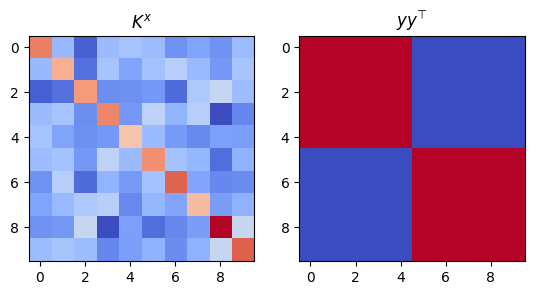

In [ ]:
depth = 3 # number of hidden N neuron layers
#eta = 0.10
#T = 100
#P = 10
eta = 0.1
T = 100
P = 10
#eta = 0.05

key = random.PRNGKey(1)

"""
X_load, y_load = load_cifar_data(P)
X = jnp.array( X_load.T )
y = jnp.array( y_load )

X = X / jnp.sqrt( jnp.mean(X**2) )
print(X.shape)
D = X.shape[0]
"""

D = 25
X = random.normal(random.PRNGKey(0), (D,P))
y = 1.0 * (jnp.linspace(1,P,P) > P/2.0) - 1.0 * (jnp.linspace(1,P,P) <= P/2.0)

Kx = X.T @ X / X.shape[0]
print(jnp.mean(Kx**2))
s,v = jnp.linalg.eigh(Kx+1e-8*jnp.eye(P))

plt.subplot(1,2, 1)
plt.imshow(Kx, cmap = 'coolwarm')
plt.title(r'$K^x$')
plt.subplot(1,2,2)
plt.imshow( jnp.outer(y, y), cmap = 'coolwarm' )
plt.title(r'$y y^\top$')
plt.show()
#y = -1.0*np.ones(P)
#y[0:P//2]= np.ones(P//2)

#Kx = jnp.array(Kx)
#y = jnp.array(y)
#print(y)

gamma = 1.0
beta = 0.8
nonlin = 'tanh'

#gamma = 0.25
#beta = 5.0
#nonlin = 'softplus'

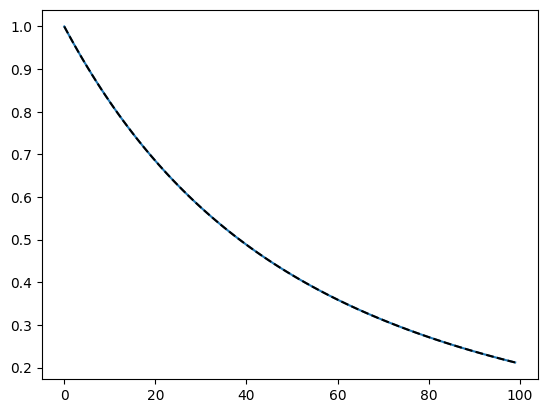

 iteration: 0 | layer 3 / 3

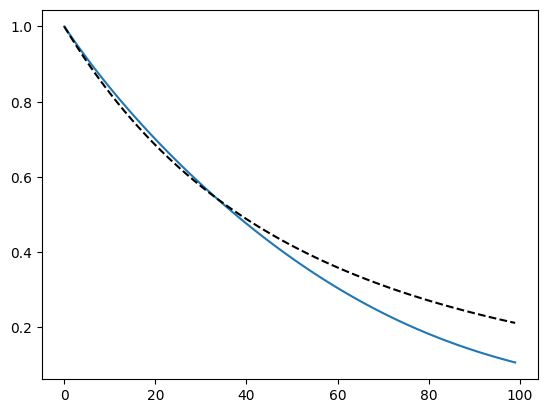

 iteration: 1 | layer 3 / 3

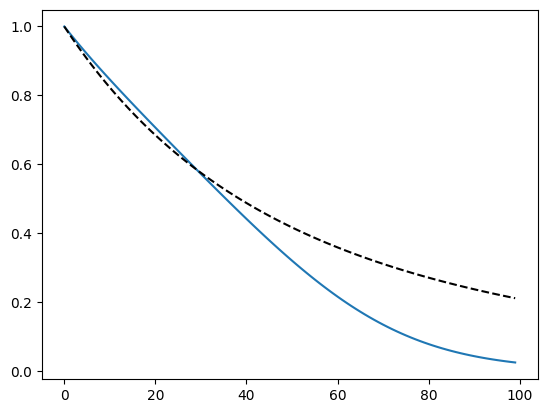

 iteration: 2 | layer 3 / 3

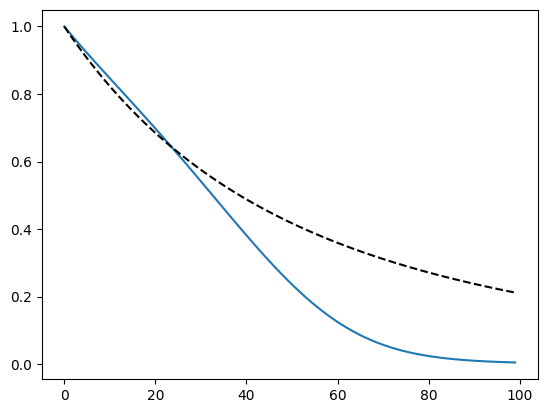

 iteration: 3 | layer 3 / 3

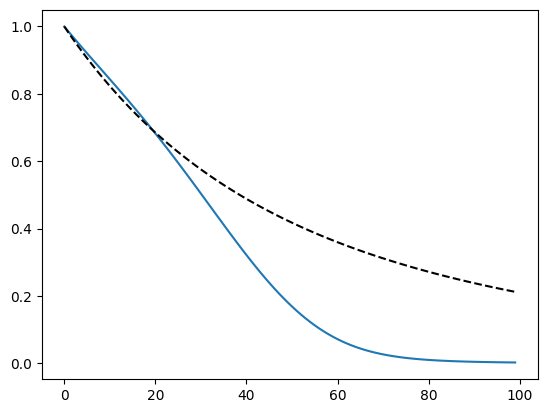

 iteration: 4 | layer 3 / 3

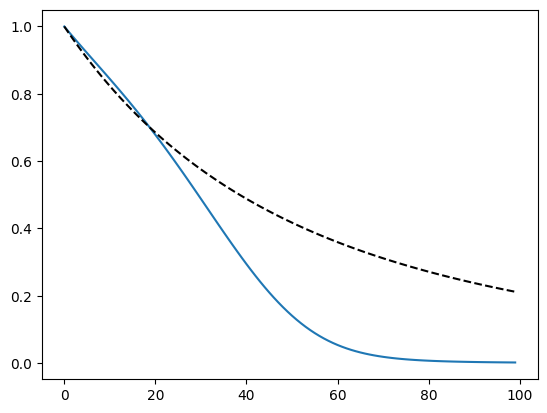

 iteration: 5 | layer 3 / 3

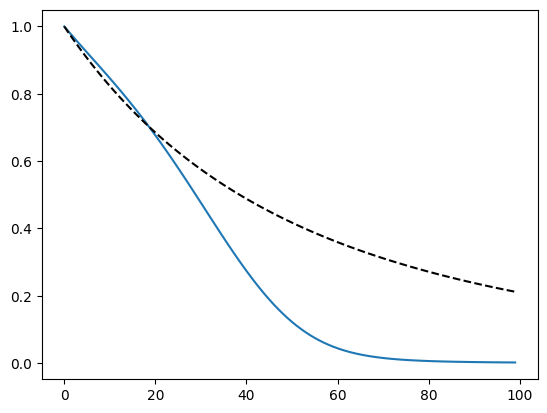

 iteration: 6 | layer 3 / 3

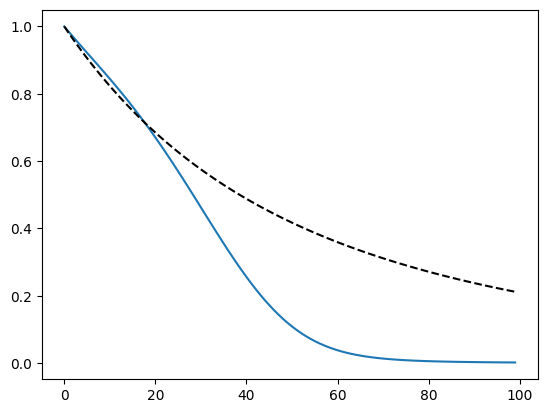

 iteration: 7 | layer 3 / 3

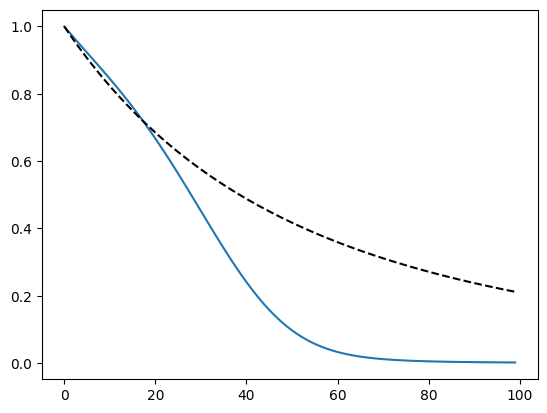

 iteration: 8 | layer 3 / 3

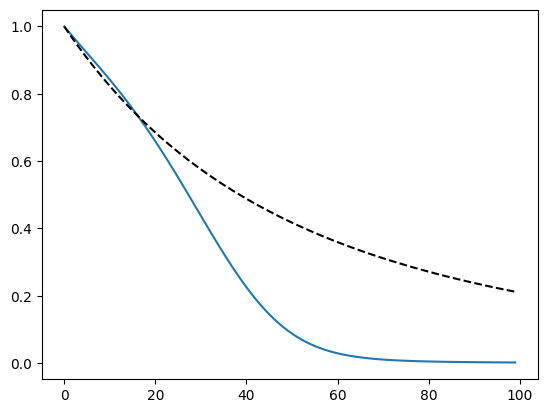

 iteration: 9 | layer 3 / 3

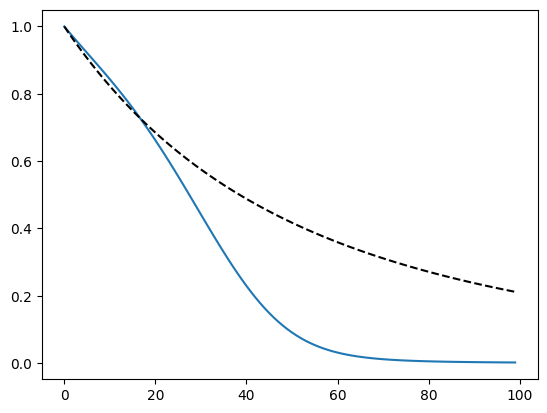

 iteration: 10 | layer 3 / 3

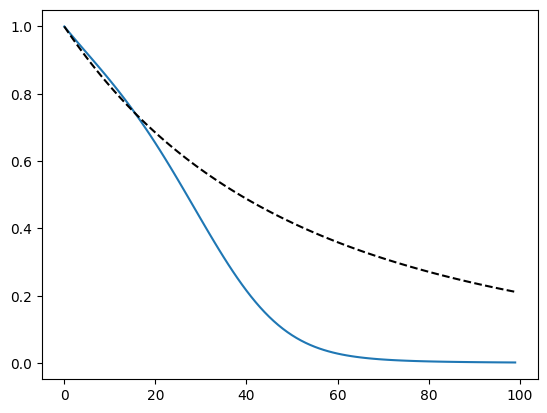

 iteration: 11 | layer 3 / 3

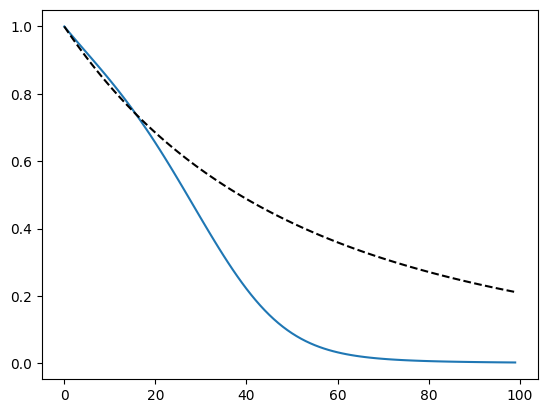

 iteration: 12 | layer 3 / 3

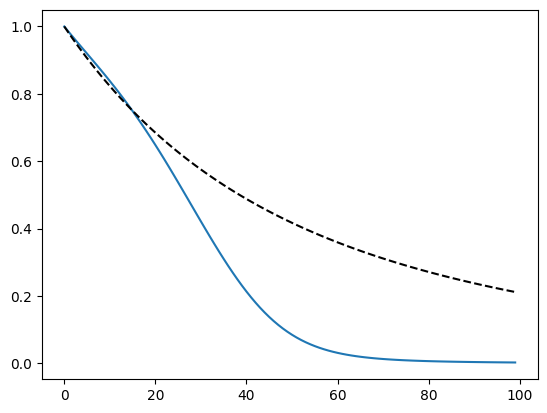

 iteration: 13 | layer 3 / 3

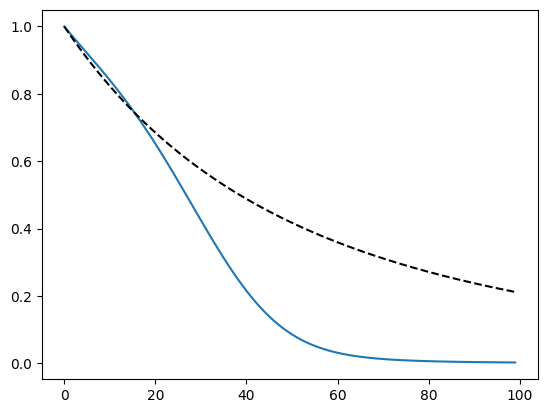

 iteration: 14 | layer 3 / 3

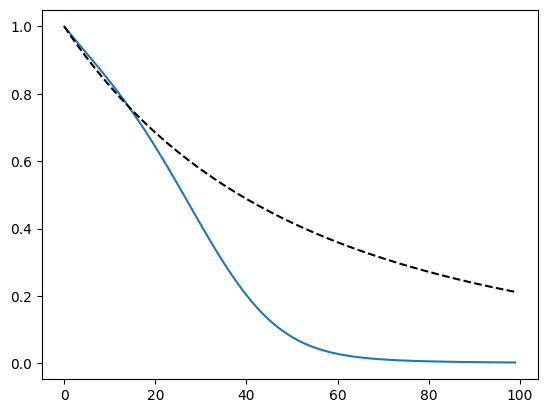

 iteration: 15 | layer 3 / 3

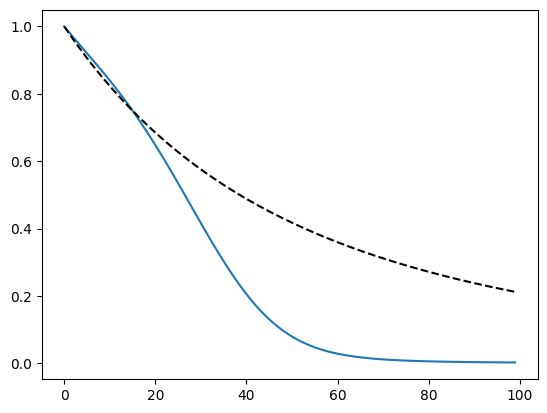

 iteration: 16 | layer 3 / 3

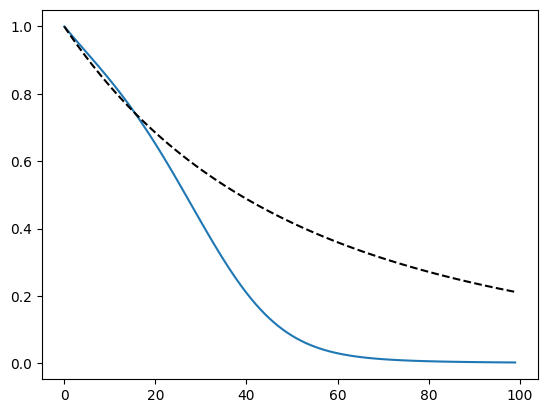

 iteration: 17 | layer 3 / 3

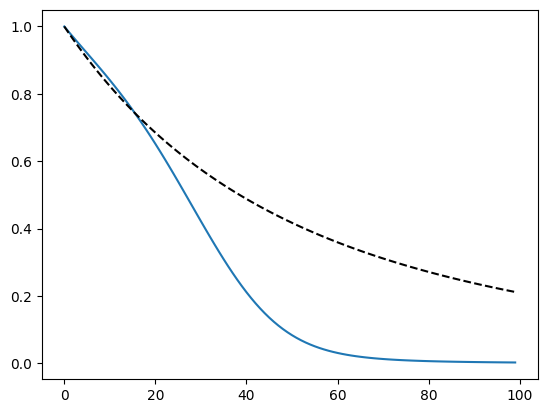

 iteration: 18 | layer 3 / 3

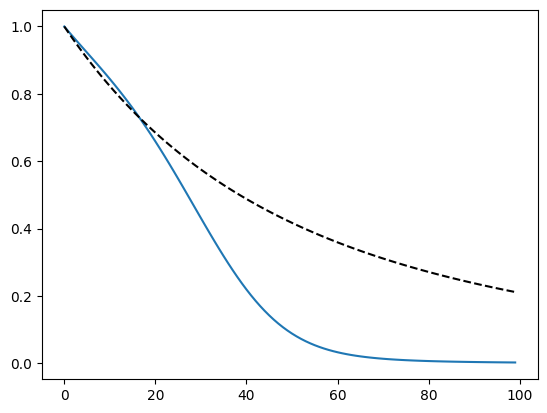

 iteration: 19 | layer 3 / 3

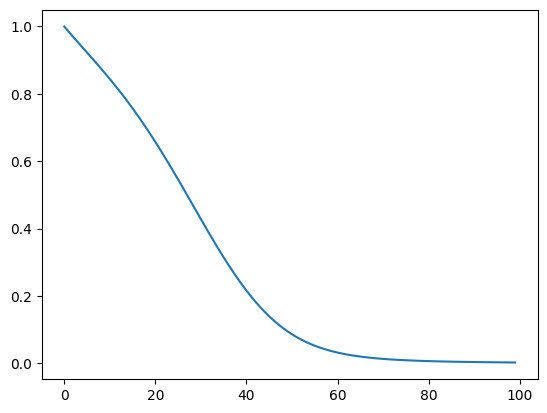

In [ ]:
all_Phi, all_G, all_A,all_B = DMFT_Theory_Cross_Term(Kx, y, depth=depth, eta=eta, T=T, gamma = gamma, nonlin=nonlin, samples = 1000, beta = beta, num_iter = 20, alpha = 0.7)
Delta = solve_Delta(Kx, y, all_Phi, all_G, eta)
plt.plot(jnp.mean(Delta**2, axis = 1))
plt.show()

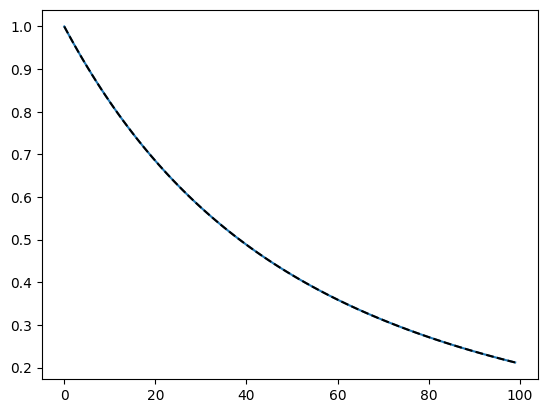

 iteration: 0 | layer 3 / 3

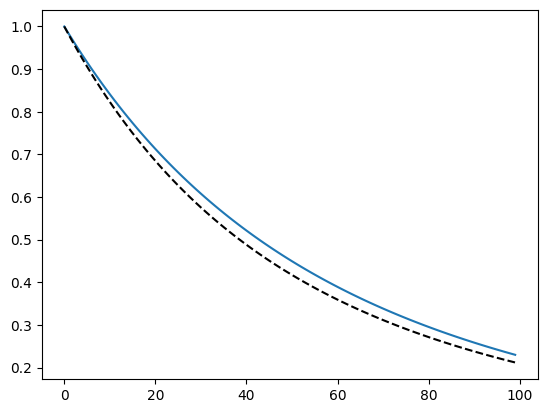

 iteration: 1 | layer 3 / 3

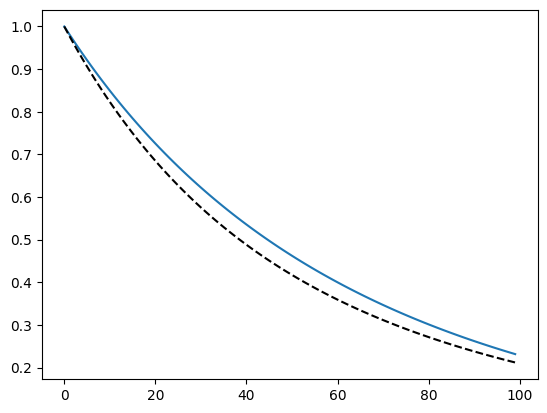

 iteration: 2 | layer 3 / 3

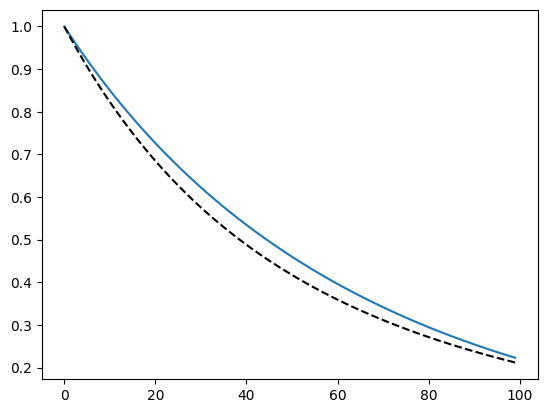

 iteration: 3 | layer 3 / 3

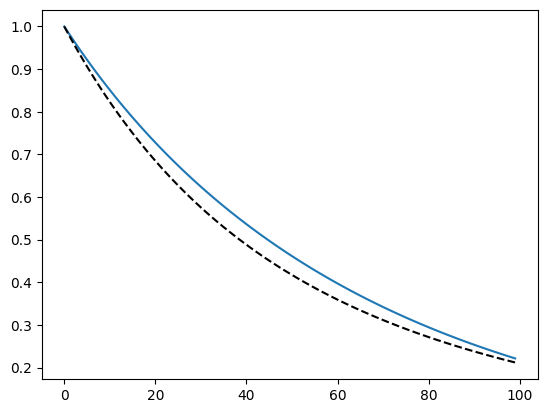

 iteration: 4 | layer 3 / 3

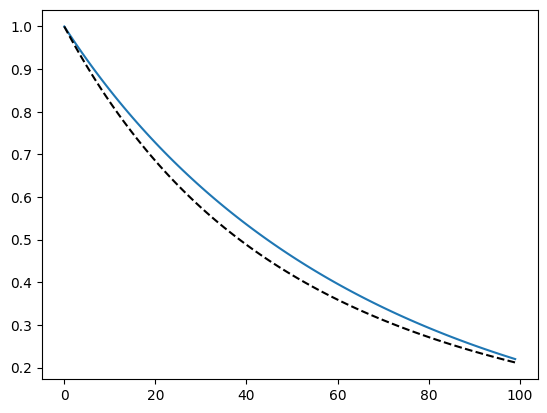

 iteration: 5 | layer 3 / 3

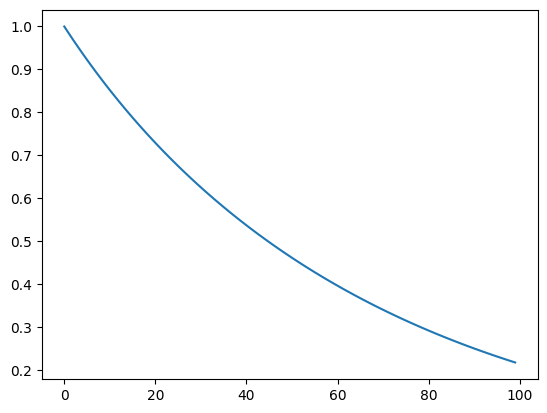

In [ ]:
all_Phi_lazy, all_G_lazy, all_A_lazy, all_B_lazy = DMFT_Theory_Cross_Term(Kx, y, depth=depth, eta=eta, T=T, gamma = 0.2*gamma, nonlin = nonlin, samples = 1000, alpha = 0.8, beta = beta, num_iter= 6)
Delta_lazy = solve_Delta(Kx, y, all_Phi_lazy, all_G_lazy, eta)
plt.plot(jnp.mean(Delta_lazy**2, axis = 1))
plt.show()

In [ ]:
def construct_NN(depth, N, D, key):
    params = [random.normal(key, (N, D))]
    for l in range(depth -1):
        key,_ = random.split(key)
        params += [random.normal(key, (N,N))]
    params += [random.normal(key, (N,))]
    return params

def nonlin_tanh(h, beta=1.0):
    return jnp.tanh(beta*h)/beta

def nonlin_dtanh(h,beta=1.0):
    return 1.0 - jnp.tanh(beta*h)**(2)


def NN_func(params, X, y, gamma, nonlin_fn):
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    L = len(params)-1
    N = params[0].shape[0]
    
    for l in range(L-1):
        
        phi = nonlin_fn(h)
        h = params[l+1] @ phi / jnp.sqrt(N)
    phi = nonlin_fn(h)
    return phi.T @ params[L] / ( N * gamma)

def NN_train(X, y, depth, N, eta, gamma, nonlin='softplus', beta = 1.0, seed = 0):
    params= construct_NN(depth, N, D = X.shape[0], key= random.PRNGKey(seed))
    opt_init, opt_update, get_params = optimizers.sgd(eta * gamma**2 * N)
    opt_state = opt_init(params)
    params0 = params
    if nonlin == 'softplus':
        nonlin_fn = lambda h: jnp.sqrt(2.0)/beta * jnp.log(1.0 + jnp.exp(beta*h))
    elif nonlin == 'rect_quad':
        nonlin_fn = lambda h: (h>0.0) * h**2
    else:
        nonlin_fn = lambda h: nonlin_tanh(h, beta)
    loss = lambda params: 0.5 * jnp.mean( (NN_func(params, X, y, gamma, nonlin_fn=nonlin_fn)-NN_func(params0,X,y, gamma, nonlin_fn) - y )**2 )
    #loss = lambda params: 0.5 * jnp.mean( (NN_func(params, X, y, gamma, nonlin_fn=nonlin_fn) - y )**2 )
    grad_fn = grad(loss)
    losses = []
    all_phi_t = np.zeros((depth,N,T,P))
    all_g_t = np.zeros((depth,N,T,P))
    all_h_t = np.zeros((depth,N,T,P))
    all_z_t = np.zeros((depth,N,T,P))
    for t in range(T):
        losses += [2.0*loss(get_params(opt_state))]
        opt_state = opt_update(t, grad_fn(get_params(opt_state)), opt_state)
        all_phi, all_h, all_chi, all_g, all_z, all_xi = get_features_forward_back(get_params(opt_state), params0, X, y, nonlin, beta = beta)
        
        for l in range(depth):
            all_phi_t[l,:,t,:] = all_phi[l]
            all_g_t[l,:,t,:] = all_g[l]
            all_h_t[l,:,t,:] = all_h[l]
            all_z_t[l,:,t,:] = all_z[l]
    return losses, get_params(opt_state), params0, all_phi_t, all_g_t, all_h_t, all_z_t

def get_features(params, params0, X, y, nonlin = 'softplus'):
    all_phi = []
    all_h = []
    all_chi = []
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    chi = params0[0] @ X / jnp.sqrt(X.shape[0])
    all_chi += [chi]
    all_h += [h]
    L = len(params)-1
    N = params[0].shape[0]
    if nonlin == 'relu':
        nonlin_fn = lambda h: (h>0.0)*h
    elif nonlin == 'rect_quad':
        nonlin_fn = lambda h: (h>0.0) * h**2
    else:
        nonlin_fn = nonlin_tanh
    for l in range(L-1):
        
        phi = nonlin_fn(h)
        all_phi += [phi]
        h = params[l+1] @ phi / jnp.sqrt(N)
        all_h += [h]
        chi = params0[l+1] @ phi / jnp.sqrt(N)
        all_chi += [chi]
    phi = nonlin_fn(h)
    all_phi += [phi]
    return all_phi, all_h, all_chi

def get_features_forward_back(params, params0, X, y,nonlin = 'softplus', beta = 1.0):
    all_phi = []
    all_h = []
    all_chi = []
    h = params[0] @ X / jnp.sqrt(X.shape[0])
    chi = params0[0] @ X / jnp.sqrt(X.shape[0])
    all_chi += [chi]
    all_h += [h]
    L = len(params)-1
    N = params[0].shape[0]
    if nonlin == 'softplus':
        nonlin_fn = lambda h: jnp.sqrt(2.0)/beta * jnp.log(1.0 + jnp.exp(beta*h))
        dnonlin_fn = lambda h: jnp.sqrt(2.0)/(1.0 + jnp.exp(-1.0*beta*h))
    elif nonlin == 'rect_quad':
        nonlin_fn = lambda h: (h>0.0) * h**2
        dnonlin_fn = lambda h: 2.0 * (h>0.0) * h
    else:
        nonlin_fn = lambda h: nonlin_tanh(h, beta)
        dnonlin_fn = lambda h: nonlin_dtanh(h,beta)
        
    for l in range(L-1):
        phi = nonlin_fn(h)
        all_phi += [phi]
        h = params[l+1] @ phi / jnp.sqrt(N)
        all_h += [h]
        chi = params0[l+1] @ phi / jnp.sqrt(N)
        all_chi += [chi]
    phi = nonlin_fn(h)
    all_phi += [phi]
    
    all_z = []
    all_g = []
    all_xi = []
    z_L = jnp.outer(params[-1],jnp.ones(X.shape[1]))
    xi_L = jnp.outer(params0[-1],jnp.ones(X.shape[1]))
    #g_L = z_L * nonlin_dtanh(all_h[-1])
    #g_L = z_L * (all_h[-1] > 0.0)
    g_L = z_L * dnonlin_fn(all_h[-1])
    
    all_z += [ z_L ]
    all_xi += [ xi_L ]
    all_g += [ g_L ]
    
    for l in range(L-1):
        z_l = 1/jnp.sqrt(N) * params[-2-l].T @ all_g[0]
        
        #g_l = z_l * (all_h[-2-l] > 0.0) 
        #g_l = z_l * nonlin_dtanh(all_h[-2-l])
        g_l = z_l * nonlin_dtanh(all_h[-2-l])
        xi_l = 1/jnp.sqrt(N) * params0[-2-l].T @ all_g[0]
        all_z.insert(0, z_l)
        all_g.insert(0, g_l)
        all_xi.insert(0, xi_l)
    
    return all_phi, all_h, all_chi, all_g, all_z, all_xi


In [ ]:
N = 2000
losses, params, params0, all_phi_t, all_g_t, all_h_t, all_z_t = NN_train(X, y, depth, N, eta, gamma = gamma, nonlin=nonlin, beta = beta)
losses0, params_lazy, params0_lazy, _, _, _, _ = NN_train(X, y, depth, N, eta, gamma = 0.2*gamma, nonlin = nonlin, beta = beta)

In [ ]:
file_dir = 'stored_results/'
print(nonlin)
np.save(file_dir + 'dmft_vs_lazy_Phi_depth_%d_gamma_%d_tanh.npy' % (depth, int(10*gamma)), all_Phi)
np.save(file_dir + 'dmft_vs_lazy_G_depth_%d_gamma_%d_tanh.npy' %  (depth, int(10*gamma)), all_G)
np.save(file_dir + 'dmft_vs_lazy_A_depth_%d_gamma_%d_tanh.npy' %  (depth, int(10*gamma)), all_A)
np.save(file_dir + 'dmft_vs_lazy_B_depth_%d_gamma_%d_tanh.npy' %  (depth, int(10*gamma)), all_B)


np.save(file_dir + 'dmft_vs_lazy_NN_h_depth_%d_gamma_%d_tanh.npy' % (depth, int(10*gamma)), all_h_t)
np.save(file_dir + 'dmft_vs_lazy_NN_z_depth_%d_gamma_%d_tanh.npy' %  (depth, int(10*gamma)), all_z_t)
np.save(file_dir + 'dmft_vs_lazy_NN_phi_depth_%d_gamma_%d_tanh.npy' %  (depth, int(10*gamma)), all_phi_t)
np.save(file_dir + 'dmft_vs_lazy_NN_g_depth_%d_gamma_%d_tanh.npy' %  (depth, int(10*gamma)), all_g_t)


tanh


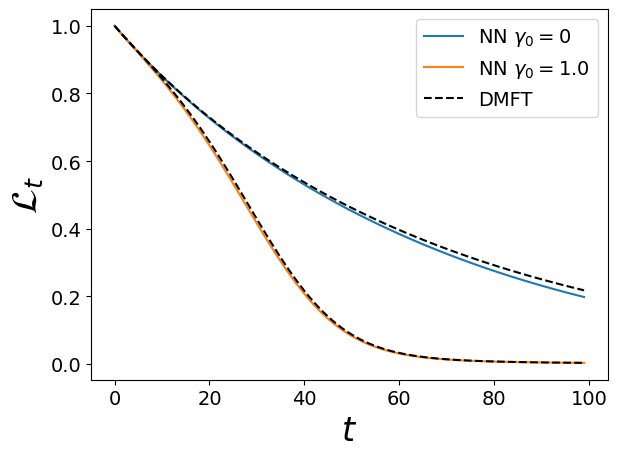

In [ ]:
#plt.figure(figsize = (8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(jnp.array(losses0)/losses0[0], color = 'C0', label = r'NN $\gamma_0 = 0$')
plt.plot(losses, color ='C1', label = r'NN $\gamma_0 = %0.1f$' % gamma)
plt.plot(jnp.mean(Delta_lazy**2, axis = 1), '--', color = 'black', label = r'DMFT')
plt.plot(jnp.mean(Delta**2, axis = 1), '--', color = 'black')
plt.legend()
plt.xlabel(r'$t$',fontsize= 24)
plt.ylabel(r'$\mathcal{L}_t$',fontsize= 26)
#plt.ylim([0,10.1])
plt.tight_layout()
#plt.savefig('final_theory_figs/loss_dynamics_jacobianMC_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
plt.show()


In [ ]:
all_chi_th, all_h_th, all_xi_th, all_z_th = sample_chi_h_xi_z(all_Phi, all_G, all_A, all_B, Kx, nonlin = nonlin, samples = 2000)


In [ ]:


#all_phi, all_h, all_chi, all_g, all_z, all_xi = get_features_forward_back(params, params0, X, y, nonlin = nonlin, beta=beta)
#all_phi0, all_h0, all_chi_0, all_g0, all_z0 , all_xi_0 = get_features_forward_back(params0, params0, X, y, nonlin = nonlin, beta=beta)

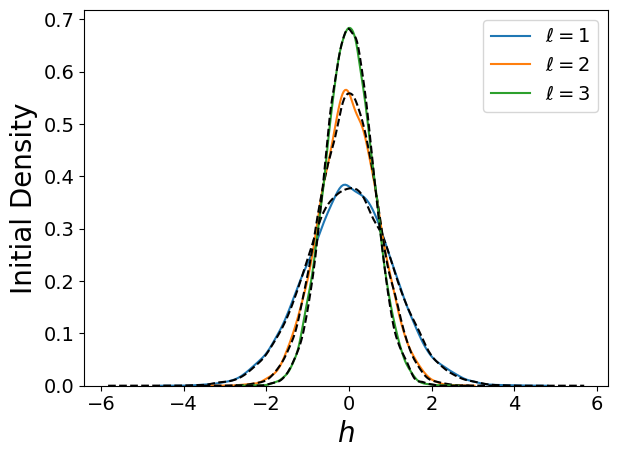

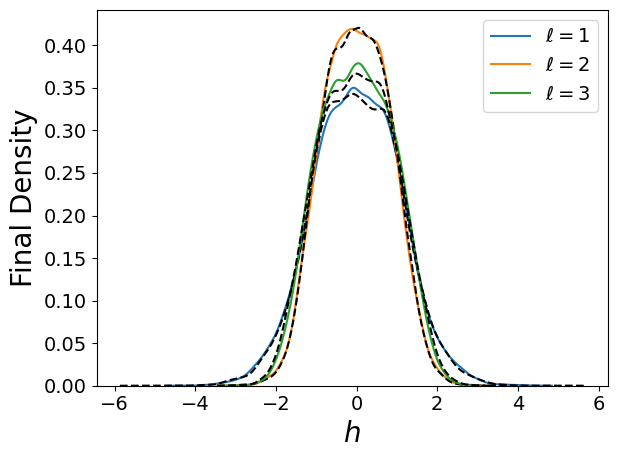

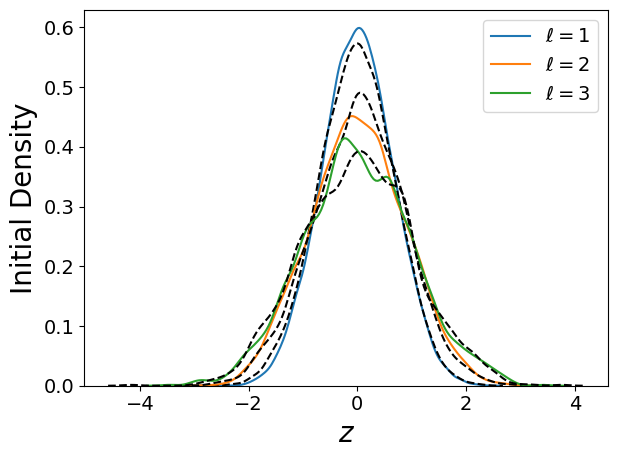

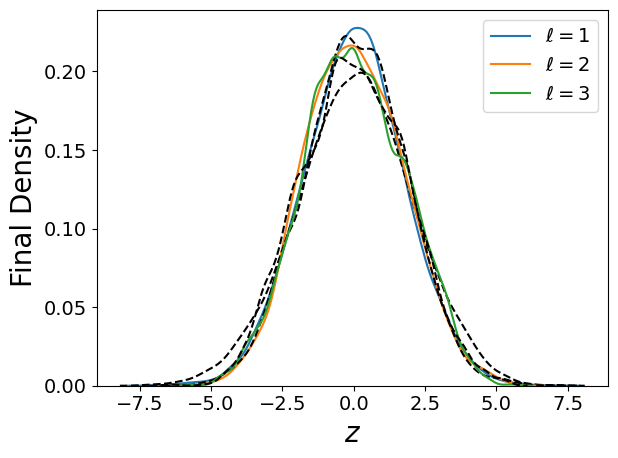

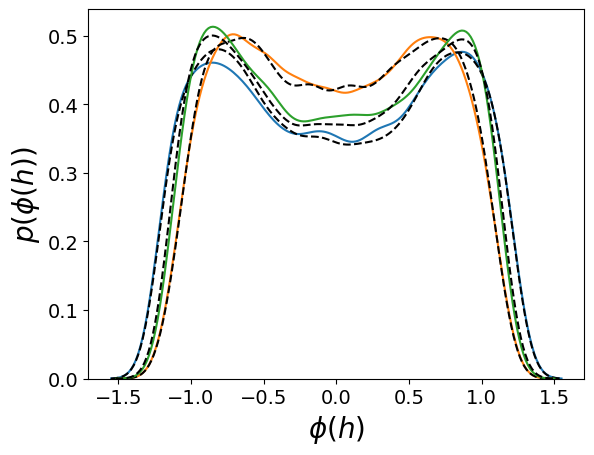

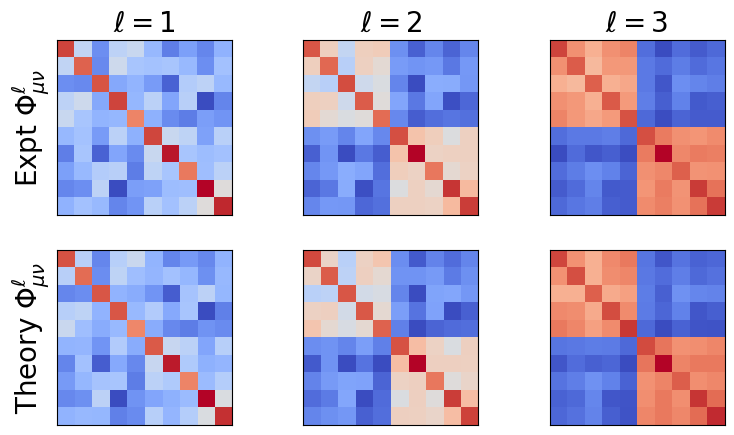

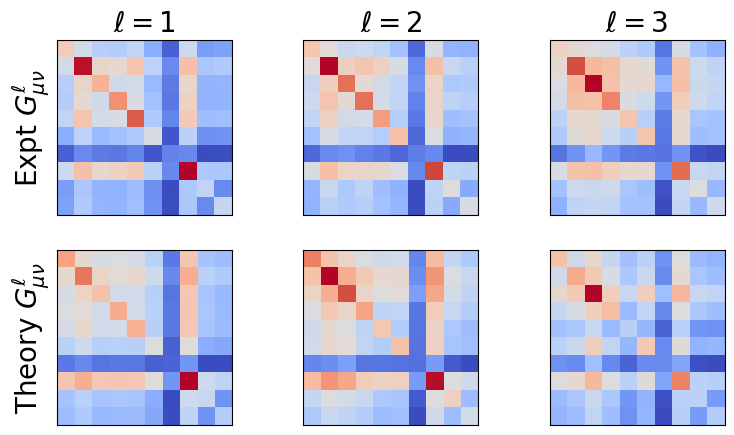

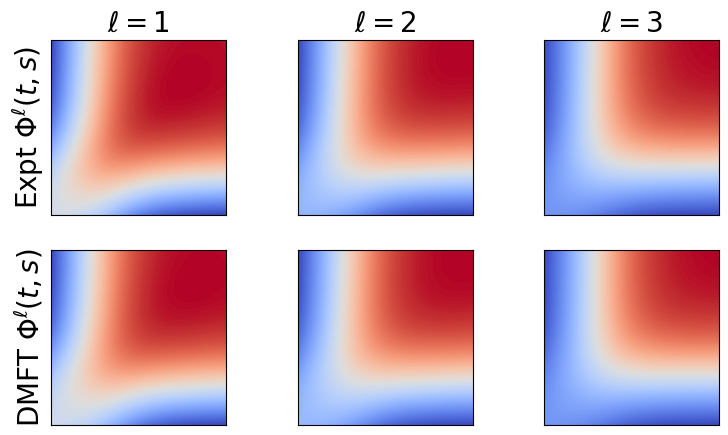

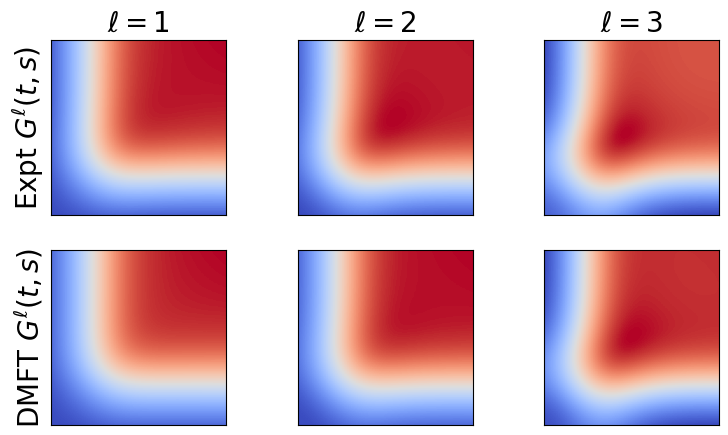

In [ ]:
bw_param =1.0
s = 10
plt.figure()
for l in range(depth):
    hl = all_h_t[l][:,0,:]
    hl_th = all_h_th[l]
    sns.kdeplot(hl.flatten(), bw_adjust = bw_param, label = r'$\ell = %d$' % (l+1))
    sns.kdeplot(hl_th[:,0,:].flatten(), bw_adjust = bw_param, linestyle='--', color = 'black')
plt.xlabel(r'$h$',fontsize = 20)
plt.ylabel(r'Initial Density',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('final_theory_figs/initial_h_dist_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
#plt.yscale('log')
plt.show()

plt.figure()
for l in range(depth):
    hl = all_h_t[l][:,-s,:]
    hl_th = all_h_th[l]
    sns.kdeplot(hl.flatten(), bw_adjust = bw_param, label = r'$\ell = %d$' % (l+1))
    sns.kdeplot(hl_th[:,-s,:].flatten(), bw_adjust = bw_param, linestyle='--', color = 'black')
plt.xlabel(r'$h$',fontsize = 20)
plt.ylabel(r'Final Density',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('final_theory_figs/final_h_dist_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
#plt.yscale('log')
plt.show()



plt.figure()
for l in range(depth):
    hl = all_z_t[l][:,0,:]
    hl_th = all_z_th[l]
    sns.kdeplot(hl.flatten(), bw_adjust = bw_param, label = r'$\ell = %d$' % (l+1))
    sns.kdeplot(hl_th[:,0,:].flatten(), bw_adjust = bw_param, linestyle='--', color = 'black')
plt.xlabel(r'$z$',fontsize = 20)
plt.ylabel(r'Initial Density',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('final_theory_figs/initial_z_dist_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
#plt.yscale('log')
plt.show()

plt.figure()
for l in range(depth):
    hl = all_z_t[l][:,-s,:]
    hl_th = all_z_th[l]
    sns.kdeplot(hl.flatten(), bw_adjust = bw_param, label = r'$\ell = %d$' % (l+1))
    sns.kdeplot(hl_th[:,-s,:].flatten(), bw_adjust = bw_param, linestyle='--', color = 'black')
plt.xlabel(r'$z$',fontsize = 20)
plt.ylabel(r'Final Density',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('final_theory_figs/final_z_dist_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
#plt.yscale('log')
plt.show()

if nonlin == 'softplus':
    nonlin_fn = lambda h: jnp.sqrt(2.0)/beta * jnp.log(1.0 + jnp.exp(beta*h))
    dnonlin_fn = lambda h: jnp.sqrt(2.0)/(1.0 + jnp.exp(-1.0*beta*h))
elif nonlin == 'rect_quad':
    nonlin_fn = lambda h: (h>0.0) * h**2
    dnonlin_fn = lambda h: 2.0 * (h>0.0) * h
else:
    nonlin_fn = lambda h: nonlin_tanh(h, beta)
    dnonlin_fn = lambda h: nonlin_dtanh(h,beta)
    
    
plt.figure()
for l in range(depth):
    phil = all_phi_t[l][:,-s,:]
    phi_th = nonlin_fn(all_h_th[l])
    sns.kdeplot(phil.flatten(), bw_adjust = bw_param)
    sns.kdeplot(phi_th[:,-s,:].flatten(), bw_adjust = bw_param, linestyle='--', color = 'black')
#plt.yscale('log')
plt.xlabel(r'$\phi(h)$',fontsize = 20)
plt.ylabel(r'$p(\phi(h))$',fontsize = 20)
#plt.savefig('final_theory_figs/final_phi_dist_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
plt.show()

plt.figure(figsize = (9,5))
#plt.figure(figsize = (10,6))
for l in range(depth):
    phil = all_phi_t[l][:,-s,:]
    Phi_expt = 1/phil.shape[0] * phil.T @ phil
    plt.subplot(2,depth, l+1)
    plt.title(r'$\ell = %d$' % (l+1), fontsize =20)
    if l == 0:
        plt.ylabel(r'Expt $\Phi^{\ell}_{\mu \nu}$',fontsize = 20)
    plt.imshow(Phi_expt, cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, depth, l+1+depth)
    plt.imshow(all_Phi[l][-s,:,-s,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])

    if l == 0:
        plt.ylabel(r'Theory $\Phi^{\ell}_{\mu \nu}$',fontsize = 20)
#plt.savefig('final_theory_figs/final_Phi_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
plt.show()

plt.figure(figsize = (9,5))

#plt.figure(figsize = (10,6))
for l in range(depth):
    phil = all_g_t[l][:,-s,:]
    G_expt = 1/phil.shape[0] * phil.T @ phil
    plt.subplot(2,depth, l+1)
    plt.title(r'$\ell = %d$' % (l+1), fontsize =20)
    if l == 0:
        plt.ylabel(r'Expt $G^{\ell}_{\mu \nu}$',fontsize = 20)
    plt.imshow(G_expt, cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, depth, l+1+depth)
    plt.imshow(all_G[l][-s,:,-s,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel(r'Theory $G^{\ell}_{\mu \nu}$',fontsize = 20)
#plt.savefig('final_theory_figs/final_G_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
plt.show()

#plt.figure(figsize = (8,4))
plt.figure(figsize = (9,5))
for l in range(depth):
    phi_l = all_phi_t[l] # N x T x P
    Phi_expt_tt = jnp.einsum('ijk,ilk->jl', phi_l, phi_l)
    Phi_dmft_tt = jnp.einsum('ijkj->ik', all_Phi[l])
    plt.subplot(2,depth, l+1)
    plt.title(r'$\ell = %d$' % (l+1), fontsize =20)
    if l == 0:
        plt.ylabel(r'Expt $\Phi^{\ell}(t,s)$',fontsize = 20)
    plt.imshow(Phi_expt_tt[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, depth, l+1+depth)
    plt.imshow(Phi_dmft_tt[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel(r'DMFT $\Phi^{\ell}(t,s)$',fontsize = 20)
#plt.savefig('final_theory_figs/final_Phitt_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
plt.show()

#plt.figure(figsize = (8,4))
plt.figure(figsize = (9,5))
for l in range(depth):
    phi_l = all_g_t[l] # N x T x P
    Phi_expt_tt = jnp.einsum('ijk,ilk->jl', phi_l, phi_l)
    Phi_dmft_tt = jnp.einsum('ijkj->ik', all_G[l])
    plt.subplot(2,depth, l+1)
    plt.title(r'$\ell = %d$' % (l+1), fontsize =20)
    if l == 0:
        plt.ylabel(r'Expt $G^{\ell}(t,s)$',fontsize = 20)
    plt.imshow(Phi_expt_tt[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(2, depth, l+1+depth)
    plt.imshow(Phi_dmft_tt[::-1,:], cmap = 'coolwarm')
    plt.xticks([])
    plt.yticks([])
    if l == 0:
        plt.ylabel(r'DMFT $G^{\ell}(t,s)$',fontsize = 20)
#plt.savefig('final_theory_figs/final_Gtt_dmft_vs_lazy_'+ nonlin + '_depth_%d_gamma_%d_beta_%d_P_%d.pdf' % (depth, 10*gamma, 10*beta, P))
plt.show()

## Sweep over Width (Convergence plots may look a bit different than main text if using synthetic data vs CIFAR)

In [ ]:
Nvals = [2, 5, 10, 25, 50,100,250,500,1000,2000]
trials = 10
all_Phi_aligns= np.zeros((len(Nvals), depth, trials))
all_G_aligns= np.zeros((len(Nvals), depth, trials))

for i,N in enumerate(Nvals):
    for q in range(trials):
        losses, params, params0, all_phi_t, all_g_t, all_h_t, all_z_t = NN_train(X, y, depth, N, eta, gamma = gamma, nonlin=nonlin, beta = beta, seed=q)
        for l in range(depth):
            phi_l = all_phi_t[l,:,:,:] # N x T x P
            g_l   = all_g_t[l,:,:,:]   # N x T x P
            Phi_expt = jnp.einsum('ijk,ilm->jklm',phi_l,phi_l)/phi_l.shape[0]
            G_expt = jnp.einsum('ijk,ilm->jklm', g_l, g_l)/g_l.shape[0]
            all_Phi_aligns[i,l,q] = jnp.sum(all_Phi[l]*Phi_expt)/jnp.sqrt( jnp.sum(all_Phi[l]**2) * jnp.sum(Phi_expt**2) )
            all_G_aligns[i,l,q] = jnp.sum(all_G[l]*G_expt)/jnp.sqrt(jnp.sum(all_G[l]**2)*jnp.sum(G_expt**2))


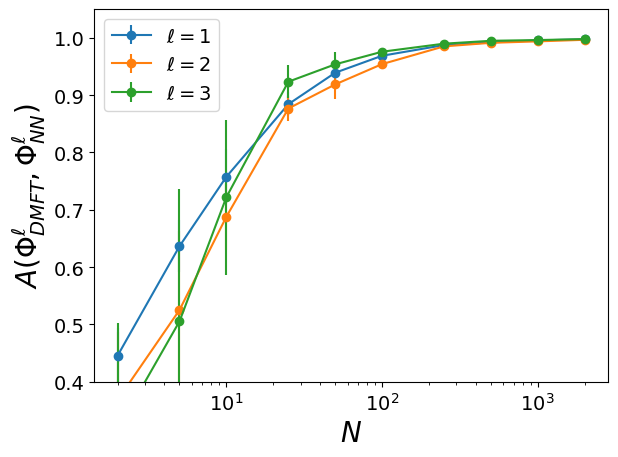

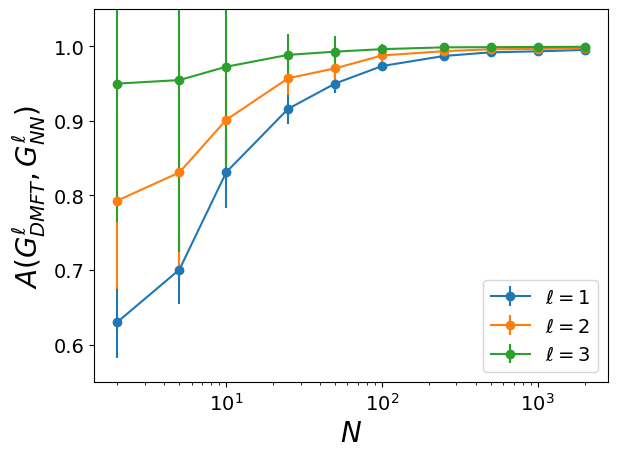

In [ ]:
for l in range(depth):
    plt.errorbar(Nvals, np.mean(all_Phi_aligns[:,l,:], axis = 1), np.std(all_Phi_aligns[:,l,:], axis = 1), marker='o', label = r'$\ell = %d$' % (l+1))
plt.xscale('log')
#plt.ylim([0.4, 1.05])
plt.ylabel(r'$A(\Phi^{\ell}_{DMFT}, \Phi^{\ell}_{NN})$',fontsize = 20)
plt.xlabel(r'$N$',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('final_theory_figs/Phi_vary_N_DMFT_vs_Expt.pdf')
plt.show()

for l in range(depth):
    plt.errorbar(Nvals, np.mean(all_G_aligns[:,l,:], axis = 1), np.std(all_Phi_aligns[:,l,:], axis = 1), marker='o', label = r'$\ell = %d$' % (l+1))
plt.xscale('log')
#plt.ylim([0.55, 1.05])
plt.ylabel(r'$A(G^{\ell}_{DMFT}, G^{\ell}_{NN})$',fontsize = 20)
plt.xlabel(r'$N$',fontsize = 20)
plt.legend()
plt.tight_layout()
#plt.savefig('final_theory_figs/G_vary_N_DMFT_vs_Expt.pdf')
plt.show()